In [93]:
import torch
import gpytorch
import random
from gpytorch.likelihoods import GaussianLikelihood, DirichletClassificationLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt
import numpy as np
from alse.gp_model import DirichletGPModel

In [94]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

In [95]:
def get_and_fit_gp(X, Y):
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-6, 1e-3))  # Noise-free
    gp = SingleTaskGP(X, Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

In [96]:
def get_and_fit_gp_class(X, Y):
    likelihood = DirichletClassificationLikelihood(Y[:,0].long(), learn_additional_noise=True)
    model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(100):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        optimizer.step()
    return model

Define Necessary functions

In [97]:
def hills(x):
    v = 0.5*torch.cos(x[:,0]*2-torch.pi)+torch.sin(x[:,1]+torch.pi/2)
    
    return v.unsqueeze(-1)
    
def circle(x):
    v = -(x[:,0] ** 2 + x[:,1] ** 2) + 25
    return v.unsqueeze(-1)

def yf(x):
    v = (((x[:,0]**2+x[:,1]-11)**2+(x[:,0]+x[:,1]**2-7)**2)>160)
    return v.unsqueeze(-1)

def get_rand_coord(num_rand_points):
    a = 6*torch.rand(num_rand_points)-3
    b = 6*torch.rand(num_rand_points)-3
    return torch.stack((a,b),-1)

def get_grid_coord(N):
    X, Y = torch.meshgrid(
    torch.linspace(-3, 3, N, **tkwargs), torch.linspace(-3, 3, N, **tkwargs),
    indexing='xy',)
    return torch.stack(
        (
            torch.reshape(X, (X.shape[0] * X.shape[1],)),
            torch.reshape(Y, (Y.shape[0] * Y.shape[1],)),
        ),
        dim=1,
    )

Grid of N1xN2 for plotting

In [98]:
N1, N2 = 150, 150
X, Y = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs),
    indexing='xy',
)
x = torch.stack(
    (
        torch.reshape(X, (X.shape[0] * X.shape[1],)),
        torch.reshape(Y, (Y.shape[0] * Y.shape[1],)),
    ),
    dim=1,
)

In bound points would be set to 1, else 0

In [99]:
Y_hills = (hills(x) > 0.3).reshape(N1, N2)
Y_circle = (circle(x) > 20).reshape(N1, N2)
Y_yf = yf(x).reshape(N1, N2)

reference = (Y_hills & Y_circle & Y_yf)

Created a model from random data

In [100]:
num_rand_points = 5

In [101]:
rand_x = get_grid_coord(num_rand_points)
rand_y_hills = hills(rand_x)
rand_y_circle = circle(rand_x)
rand_y_class = yf(rand_x)

Fit a model based on these points

In [102]:
def fit_all_models(rand_x, rand_y_hills, rand_y_circle, rand_y_class):
    model_hills = get_and_fit_gp(rand_x, rand_y_hills)
    model_circle = get_and_fit_gp(rand_x, rand_y_circle)
    model_class = get_and_fit_gp_class(rand_x, rand_y_class)
    ##########################################################
    model_class.eval()
    with gpytorch.settings.fast_pred_var(), torch.no_grad():
        test_dist = model_class(x)
        pred_means = test_dist.loc

    fig, ax = plt.subplots(1, 2, figsize = (20, 7))

    for i in range(2):
        im = ax[i].contourf(
            X.numpy(), Y.numpy(), pred_means[i].numpy().reshape(N1,N2),
        cmap="Blues", alpha=0.6)
        fig.colorbar(im, ax=ax[i])
        ax[i].plot(rand_x[:,0].numpy(), rand_x[:,1].numpy(), "ko")
        ax[i].set_title("Logits: Class " + str(i), fontsize = 20)
    

    pred_samples = test_dist.sample(torch.Size((256,))).exp()
    probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
    # probabilities[0] = probabilities[0]*(probabilities[0].max()-probabilities[0].min())
    probabilities[1] = probabilities[1]/probabilities[1].max()
    probabilities[0] = 1-probabilities[1]
    ###################################################################
    fig, ax = plt.subplots(1, 2, figsize = (20, 7))

    levels = np.linspace(0, 1.05, 20)
    for i in range(2):
        im = ax[i].contourf(
            X.numpy(), Y.numpy(), probabilities[i].numpy().reshape(N1,N2), levels=levels,
        cmap="Blues", alpha=0.6)
        fig.colorbar(im, ax=ax[i])
        ax[i].plot(rand_x[:,0].numpy(), rand_x[:,1].numpy(), "ko")
        ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)
    ##################################################################
    predicted_hills = model_hills(x).loc.reshape(N1,N2)
    predicted_circle = model_circle(x).loc.reshape(N1,N2)
    predicted_yf = probabilities.max(0)[1].reshape(N1,N2)
    return predicted_hills, predicted_circle, predicted_yf

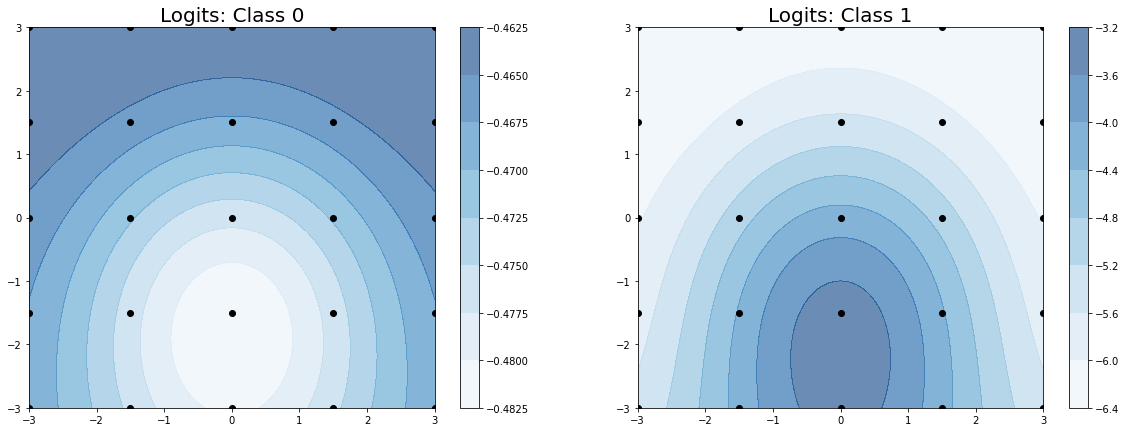

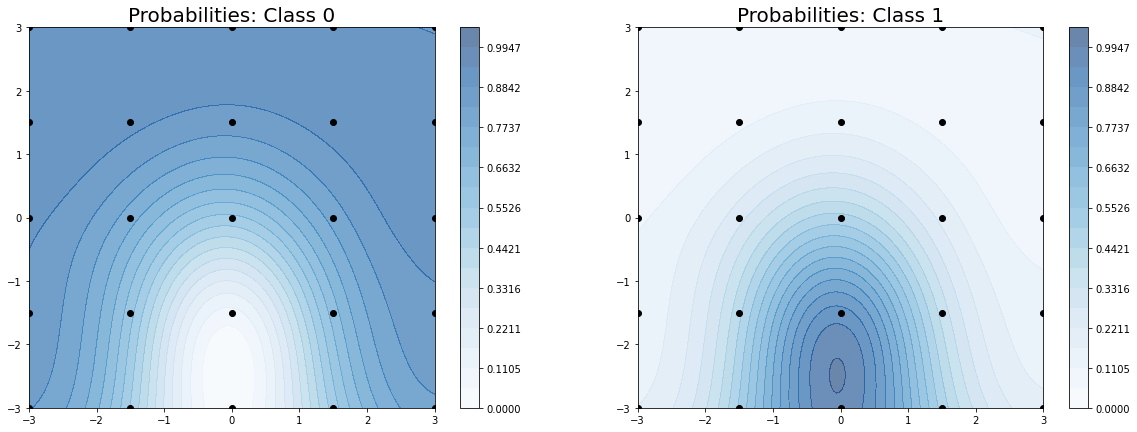

In [103]:
predicted_hills, predicted_circle, predicted_yf = fit_all_models(rand_x, rand_y_hills, rand_y_circle, rand_y_class)

Plot model 1

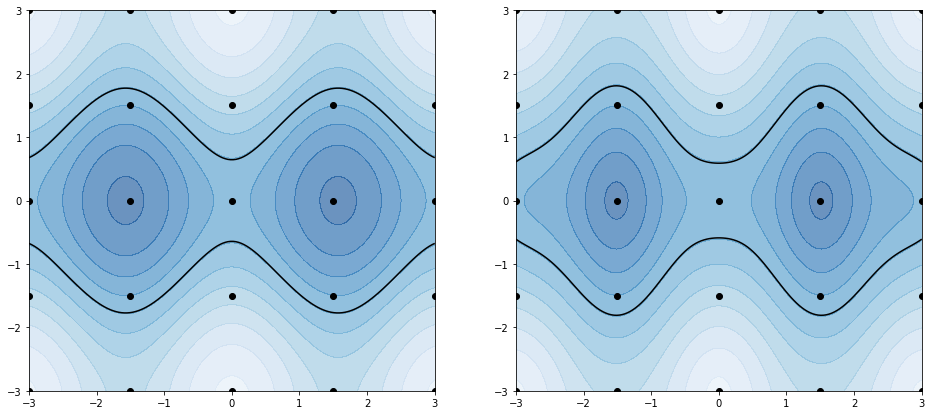

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(X, Y, hills(x).reshape(N1,N2), levels=torch.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[0].plot(rand_x[:,0], rand_x[:,1], "ko")
ax[0].contour(X, Y, hills(x).reshape(N1,N2), [0.3, 2], colors="k")
ax[1].contourf(X, Y, predicted_hills.detach(), levels=torch.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[1].contour(X, Y, predicted_hills.detach(), [0.3, 2], colors="k")
ax[1].plot(rand_x[:,0], rand_x[:,1], "ko")

Plot model 2

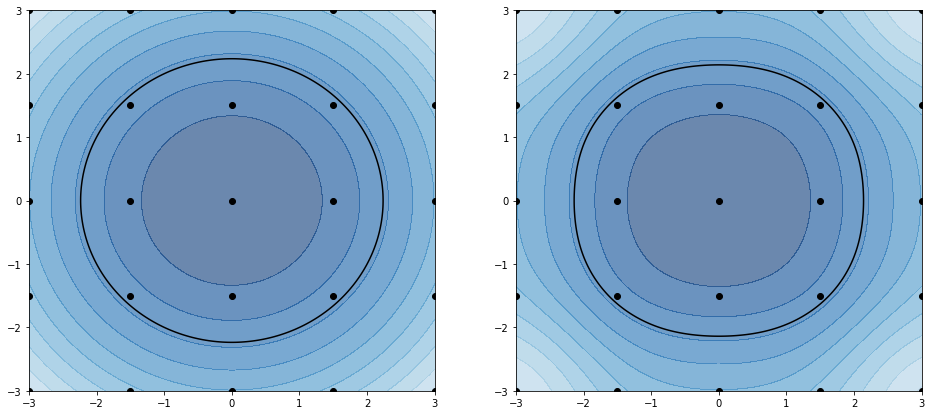

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(X, Y, circle(x).reshape(N1,N2), levels=torch.linspace(0, 25, 15), cmap="Blues", alpha=0.6)
ax[0].contour(X, Y, circle(x).reshape(N1,N2), [20, 30], colors="k")
ax[0].plot(rand_x[:,0], rand_x[:,1], "ko")
ax[1].contourf(X, Y, predicted_circle.detach(), levels=torch.linspace(0, 25, 15), cmap="Blues", alpha=0.6)
ax[1].contour(X, Y, predicted_circle.detach(), [20, 30], colors="k")
ax[1].plot(rand_x[:,0], rand_x[:,1], "ko")

Plot model 3

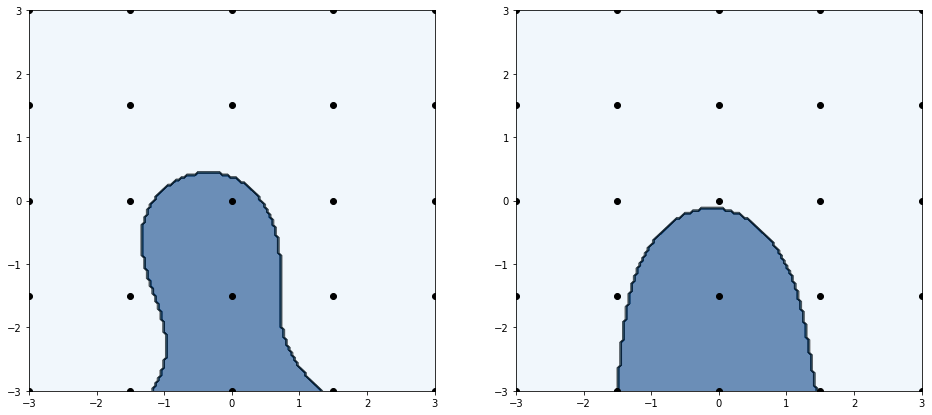

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(X, Y, yf(x).reshape(N1,N2), cmap="Blues", alpha=0.6)
ax[0].contour(X, Y, yf(x).reshape(N1,N2), linewidths=0.3, colors="k")
ax[0].plot(rand_x[:,0], rand_x[:,1], "ko")
ax[1].contourf(X.cpu(), Y.cpu(), predicted_yf, cmap="Blues", alpha=0.6)
ax[1].contour(X, Y, predicted_yf, linewidths=0.3, colors="k")
ax[1].plot(rand_x[:,0], rand_x[:,1], "ko")

Text(0.5, 1.0, 'Estimated boundary')

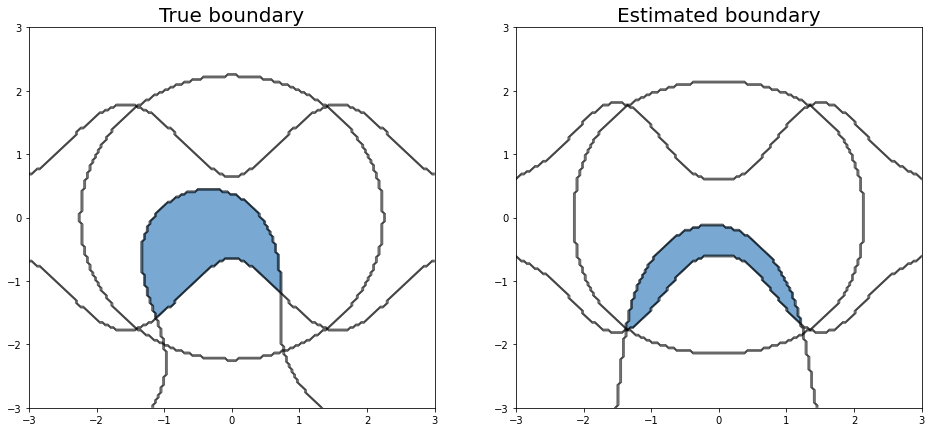

In [107]:
est_overlap = (predicted_circle > 20) & (predicted_hills > 0.3) & predicted_yf

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(X, Y, reference, levels=torch.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[0].contour(X, Y, Y_hills, linewidths=0.3, colors="k")
ax[0].contour(X, Y, Y_circle, linewidths=0.3, colors="k")
ax[0].contour(X, Y, Y_yf, linewidths=0.3, colors="k")
ax[0].set_title("True boundary", fontsize=20)


ax[1].contourf(X, Y, est_overlap, levels=torch.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[1].contour(X, Y, (predicted_hills > 0.3), linewidths=0.3, colors="k")
ax[1].contour(X, Y, (predicted_circle > 20), linewidths=0.3, colors="k")
ax[1].contour(X, Y, predicted_yf, linewidths=0.3, colors="k")
ax[1].set_title("Estimated boundary", fontsize=20)

1. Method 1
2. Find the estimated overlap, then find points that are not accurate (logic behind this is % of in bound squares we correctly identified)
3. Maybe this is not the best way to calculate accuracy? Logical & operation only considers true & true, it does not consider spills (outside the correct boundary)

In [108]:
est_overlap = (predicted_circle > 20) & (predicted_hills > 0.3) & predicted_yf

a = est_overlap & reference
accuracy = float(a.sum()/reference.sum())
accuracy = round(accuracy, 4)
print(f"Accuracy of this run: {accuracy}")


Accuracy of this run: 0.4305


1. Method 2
2. Consider this alternative method which introduce an equally weighted penalty for going out of bound

In [109]:
reward = est_overlap & reference
penalty = est_overlap & ~reference

accuracy = float((reward.sum() - penalty.sum())/reference.sum())
accuracy = round(accuracy, 4)
print(f"Accuracy of this run: {accuracy}")

Accuracy of this run: 0.3197


In [110]:
reference.sum()

tensor(1489)

In [111]:
reward.sum()

tensor(641)

In [112]:
penalty.sum()

tensor(165)

Result of random sampling using method 1

In [113]:
def test_rand():
    raw = torch.tensor([0])
    for i in range(500):
        rand_x = get_rand_coord(50)
        predicted_hills, predicted_circle, predicted_yf = fit_all_models(rand_x, hills(rand_x), circle(rand_x), yf(rand_x))

        est_overlap = (predicted_circle > 20) & (predicted_hills > 0.3) & predicted_yf
        a = (est_overlap & reference)
        accuracy = torch.tensor([round(float(a.sum()/reference.sum()), 4)])
        raw = torch.cat((raw, accuracy),0)
    #Return everything after the intial zero
    return raw[1:]

In [114]:
# trial = test_rand()


In [115]:
trial.mean()

NameError: name 'trial' is not defined